# 04 - Model Comparison: Mileage Parameterizations

This notebook compares four approaches to modeling age and mileage effects on price,
all using partial pooling (random intercepts) on categorical predictors.

**Model comparison:**
| Model | Age | Mileage | Description |
|-------|-----|---------|-------------|
| **Linear Mileage** | linear + random slope by gen | `mileage_scaled` + `is_low_mileage` | Z-scored mileage with binary indicator |
| **Log Mileage** | linear + random slope by gen | `log_mileage` | Natural log captures diminishing returns |
| **Spline (log)** | `bs(age, df=6)` | `bs(log_mileage, df=6)` | Flexible nonlinear effects on log-mileage |
| **Spline (linear)** | `bs(age, df=6)` | `bs(mileage_scaled, df=6)` | Flexible nonlinear effects on linear mileage |

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models import (
    build_model,
    build_spline_model,
    compare_models_loo,
    compare_residual_stats,
    fit_model,
    fit_spline_model,
    get_residuals,
    plot_residual_diagnostics,
    plot_spline_effects_grid,
)
from price_analysis.models.hierarchical import check_diagnostics, predict_price
from price_analysis.models.spline import predict_spline_price

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

MILEAGE_MEAN, MILEAGE_STD = df_cleaned["mileage"].mean(), df_cleaned["mileage"].std()

print(f"Model data: {len(df)} listings")
print(f"Age range: {df['age'].min()} - {df['age'].max()} years")
print(
    f"Mileage range (scaled): {df['mileage_scaled'].min():.2f} - {df['mileage_scaled'].max():.2f}"
)

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 790, 'pdk': 476, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model data: 1360 listings
Age range: 0.0 - 26.0 years
Mileage range (scaled): -1.05 - 5.03


## Build Spline Model

In [4]:
AGE_DF = 6  # Degrees of freedom for age spline
MILEAGE_DF = 6  # Degrees of freedom for mileage spline (reduced from 8)
INCLUDE_SALE_YEAR = False  # ≈all 2025 listings
TARGET_ACCEPT = 0.975

In [5]:
spline_model = build_spline_model(
    df,
    age_df=AGE_DF,
    mileage_df=MILEAGE_DF,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_color=True,
)
print(spline_model)

INFO:price_analysis.models.spline:Spline model formula: log_price ~ 1 + bs(age, df=6) + bs(log_mileage, df=6) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.spline:Built spline model with 1360 observations


       Formula: log_price ~ 1 + bs(age, df=6) + bs(log_mileage, df=6) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.5, sigma: 1.0)
            bs(age, df=6) ~ Normal(mu: 0.0, sigma: 2.0)
            bs(log_mileage, df=6) ~ Normal(mu: 0.0, sigma: 2.0)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|color_category ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 3.0)


## Prior Predictive Checks

Verify that priors for the spline model produce reasonable price predictions before fitting.

In [6]:
# Sample from prior predictive distribution
spline_model.build()
prior_idata_spline = spline_model.prior_predictive(draws=500, random_seed=42)

Sampling: [1|body_style_offset, 1|body_style_sigma, 1|color_category_offset, 1|color_category_sigma, 1|generation_offset, 1|generation_sigma, 1|trans_type_offset, 1|trans_type_sigma, 1|trim_tier_offset, 1|trim_tier_sigma, Intercept, bs(age, df=6), bs(log_mileage, df=6), log_price, sigma]
INFO:pymc.sampling.forward:Sampling: [1|body_style_offset, 1|body_style_sigma, 1|color_category_offset, 1|color_category_sigma, 1|generation_offset, 1|generation_sigma, 1|trans_type_offset, 1|trans_type_sigma, 1|trim_tier_offset, 1|trim_tier_sigma, Intercept, bs(age, df=6), bs(log_mileage, df=6), log_price, sigma]


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/3517821840.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


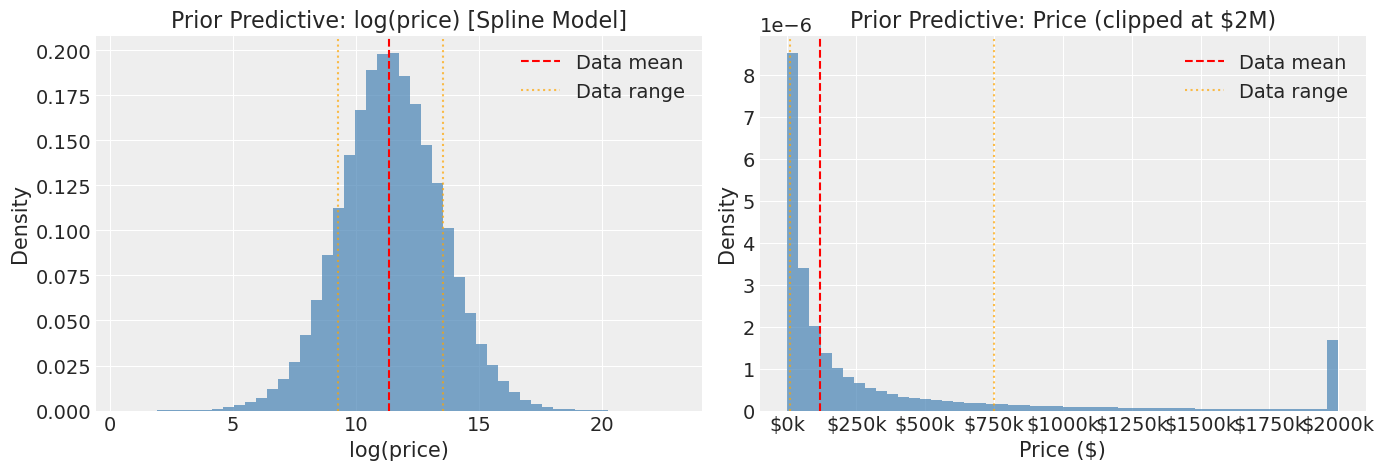

Prior log-price: mean=11.43, std=2.05
Prior log-price range: [0.56, 22.96]
Data log-price range: [9.28, 13.53]

Prior price (clipped): median=$90,163
% of prior samples > $2M: 6.6%


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prior predictive log-price distribution
y_prior = prior_idata_spline.prior_predictive["log_price"].values.flatten()
axes[0].hist(y_prior, bins=50, alpha=0.7, density=True, color="steelblue")
axes[0].axvline(df["log_price"].mean(), color="red", linestyle="--", label="Data mean")
axes[0].axvline(df["log_price"].min(), color="orange", linestyle=":", alpha=0.7, label="Data range")
axes[0].axvline(df["log_price"].max(), color="orange", linestyle=":", alpha=0.7)
axes[0].set_xlabel("log(price)")
axes[0].set_ylabel("Density")
axes[0].set_title("Prior Predictive: log(price) [Spline Model]")
axes[0].legend()

# Prior predictive price distribution
price_prior = np.exp(y_prior)
price_prior_clipped = np.clip(price_prior, 0, 2_000_000)
axes[1].hist(price_prior_clipped, bins=50, alpha=0.7, density=True, color="steelblue")
axes[1].axvline(df["sale_price"].mean(), color="red", linestyle="--", label="Data mean")
axes[1].axvline(
    df["sale_price"].min(), color="orange", linestyle=":", alpha=0.7, label="Data range"
)
axes[1].axvline(df["sale_price"].max(), color="orange", linestyle=":", alpha=0.7)
axes[1].set_xlabel("Price ($)")
axes[1].set_ylabel("Density")
axes[1].set_title("Prior Predictive: Price (clipped at $2M)")
axes[1].legend()
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x / 1000:.0f}k"))

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Prior log-price: mean={y_prior.mean():.2f}, std={y_prior.std():.2f}")
print(f"Prior log-price range: [{y_prior.min():.2f}, {y_prior.max():.2f}]")
print(f"Data log-price range: [{df['log_price'].min():.2f}, {df['log_price'].max():.2f}]")
print(f"\nPrior price (clipped): median=${np.median(price_prior_clipped):,.0f}")
print(f"% of prior samples > $2M: {(price_prior > 2_000_000).mean() * 100:.1f}%")

too many clipped ultra high value in prior imo

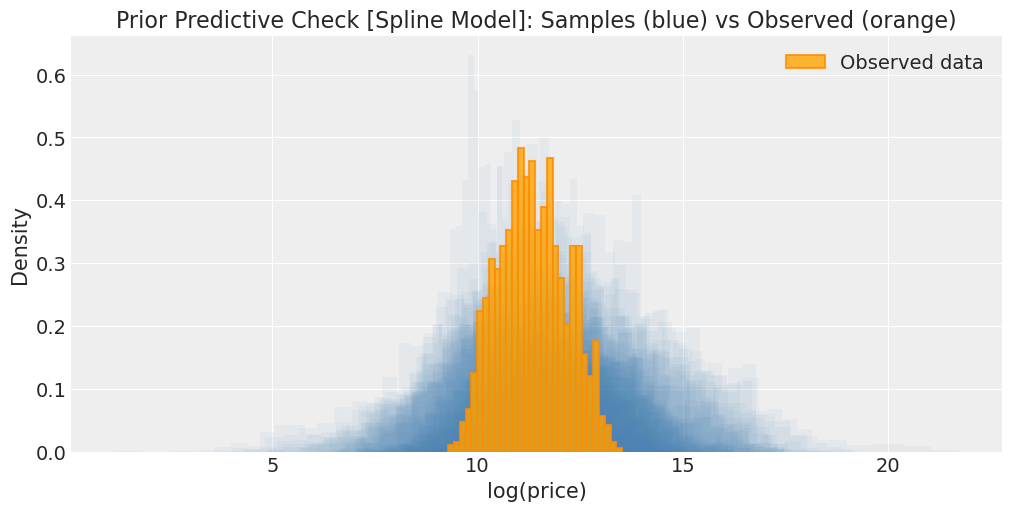

In [8]:
# PPC-style plot: prior predictive samples vs observed data
fig, ax = plt.subplots(figsize=(10, 5))

# Plot prior predictive draws (thin lines)
y_prior_2d = prior_idata_spline.prior_predictive["log_price"].values  # (chain, draw, obs)
for i in range(min(50, y_prior_2d.shape[1])):  # Plot up to 50 draws
    ax.hist(y_prior_2d[0, i, :], bins=30, alpha=0.05, color="steelblue", density=True)

# Overlay observed data
ax.hist(
    df["log_price"],
    bins=30,
    alpha=0.8,
    color="orange",
    density=True,
    label="Observed data",
    edgecolor="darkorange",
    linewidth=1.5,
)

ax.set_xlabel("log(price)")
ax.set_ylabel("Density")
ax.set_title("Prior Predictive Check [Spline Model]: Samples (blue) vs Observed (orange)")
ax.legend()
plt.show()

maybe a bit too much prior variance?

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/3023894991.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


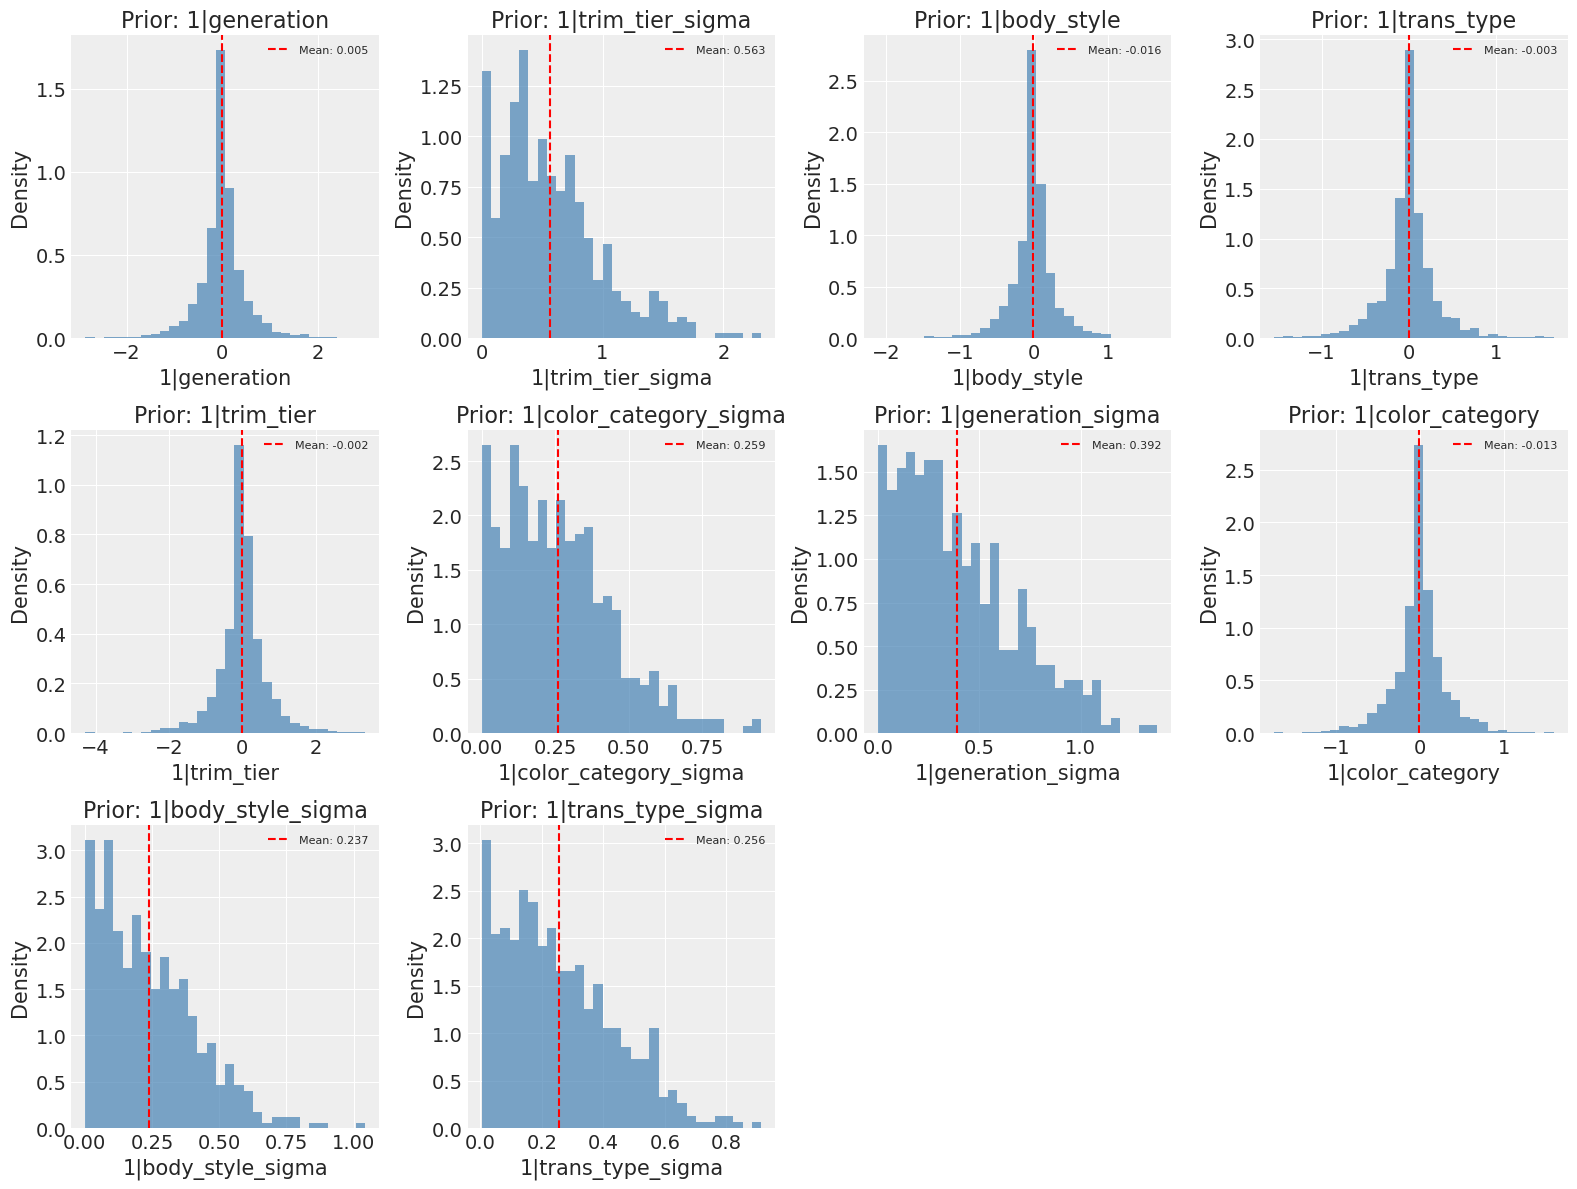

In [9]:
# Visualize prior distributions for random effect standard deviations
re_vars = [v for v in prior_idata_spline.prior.data_vars if "_sigma" in v or "1|" in v]
if re_vars:
    n_vars = len(re_vars)
    n_cols = min(n_vars, 4)
    n_rows = (n_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.atleast_1d(axes).flatten()

    for ax, var in zip(axes, re_vars):
        samples = prior_idata_spline.prior[var].values.flatten()
        ax.hist(samples, bins=30, alpha=0.7, color="steelblue", density=True)
        ax.axvline(samples.mean(), color="red", linestyle="--", label=f"Mean: {samples.mean():.3f}")
        ax.set_xlabel(var)
        ax.set_ylabel("Density")
        ax.set_title(f"Prior: {var}")
        ax.legend(fontsize=8)

    # Hide unused subplots
    for ax in axes[len(re_vars) :]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No random effect variance parameters found in prior samples")

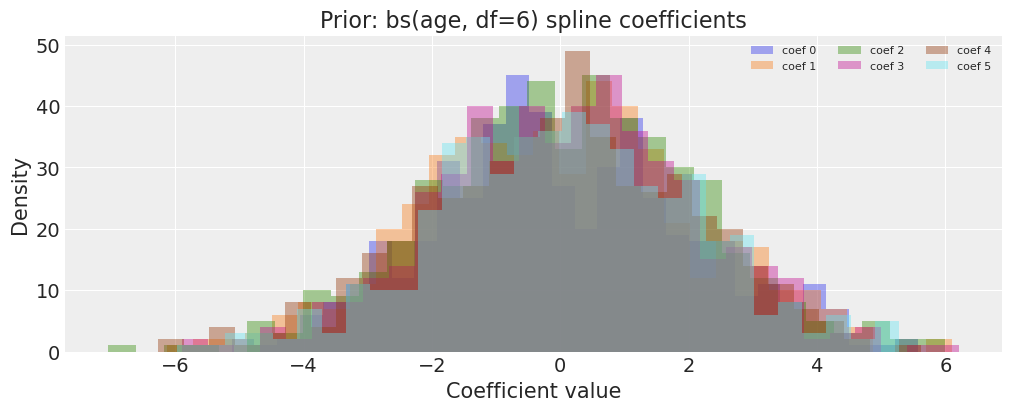

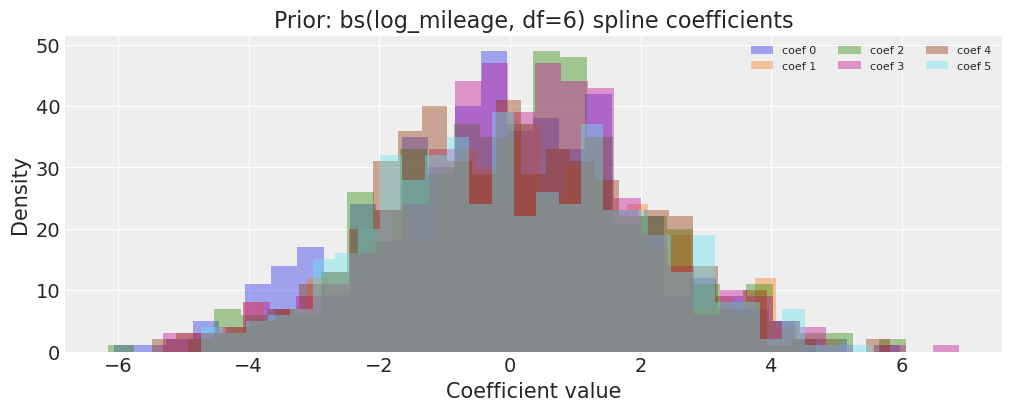

In [10]:
# Visualize prior for spline coefficients
spline_vars = [v for v in prior_idata_spline.prior.data_vars if "bs(" in v]
if spline_vars:
    for var in spline_vars[:2]:  # Show up to 2 spline terms
        samples = prior_idata_spline.prior[var].values  # (chain, draw, coef)
        fig, ax = plt.subplots(figsize=(10, 4))
        for i in range(samples.shape[-1]):
            ax.hist(samples[:, :, i].flatten(), bins=30, alpha=0.4, label=f"coef {i}")
        ax.set_xlabel("Coefficient value")
        ax.set_ylabel("Density")
        ax.set_title(f"Prior: {var} spline coefficients")
        ax.legend(ncol=3, fontsize=8)
        plt.show()

**Interpretation:**
- **Overlay plot:** Blue histograms show individual prior predictive draws; orange shows observed data. Good priors should have draws that "cover" the observed distribution without being wildly diffuse.
- **Random effects:** The σ parameters control how much variation each grouping factor explains.
- **Spline coefficients:** These control the flexibility of the age/mileage curves. Very large priors allow extreme wiggles; tight priors enforce smoother curves.

If the priors seem too diffuse or too tight, adjust priors in `src/price_analysis/models/spline.py`.

## Fit Spline Model

In [11]:
%%time
idata_spline = fit_spline_model(
    spline_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.spline:Fitting spline model: 1000 draws, 1000 tune, 8 chains
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, bs(age, df=6), bs(log_mileage, df=6), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, bs(age, df=6), bs(log_mileage, df=6), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 121 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 121 seconds.
INFO:price_analysis.models.spline:Model summary:
                            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                      0.193  0.004   0.187    0.200      0.000    0.000   
Intercept                 12.401  0.301  11.836   12.970      0.005    0.004   
bs(age, df=6)[0]           0.043  0.094  -0.135    0.214      0.001    0.001   
bs(age, df=6)[1]           0.164  0.109  -0.035    0.374      0.001    0.001   
bs(age, df=6)[2]          -0.343  0.114  -0.570   -0.142      0.002    0.001   
bs(age, df=6)[3]          -0.523  0.117  -0.744   -0.300      0.002    0.001   
bs(age, df=6)[4]          -0.776  0.132  -1.008   -0.518      0.003    0.002   
bs(age, df=6)[5]          -0.734  0.126  -0.946   -0.478      0.002    0.001 

CPU times: user 8.61 s, sys: 730 ms, total: 9.34 s
Wall time: 2min 3s


## Diagnostics

In [12]:
diagnostics = check_diagnostics(idata_spline)
print(f"Converged: {diagnostics['converged']}")
print(f"Divergences: {diagnostics['n_divergences']}")
print(f"Max R-hat: {diagnostics['rhat_max']:.3f}")
print(f"Min ESS (bulk): {diagnostics['ess_bulk_min']:.0f}")
if diagnostics["issues"]:
    print(f"Issues: {diagnostics['issues']}")

Converged: True
Divergences: 0
Max R-hat: 1.000
Min ESS (bulk): 2653


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>]], dtype=object)

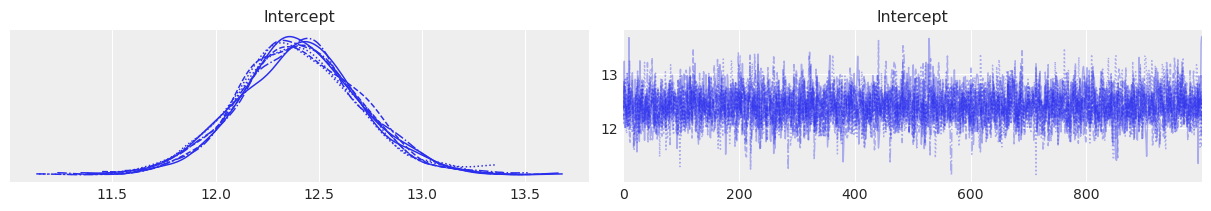

In [13]:
var_names = ["Intercept"]
az.plot_trace(idata_spline, var_names=var_names)

## Visualize Spline Effects

These plots show the estimated nonlinear relationship between age/mileage and log(price),
holding other variables at their median/mode values.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/spline.py:385: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Text(0.5, 1.02, 'Spline Effects on log(price)')

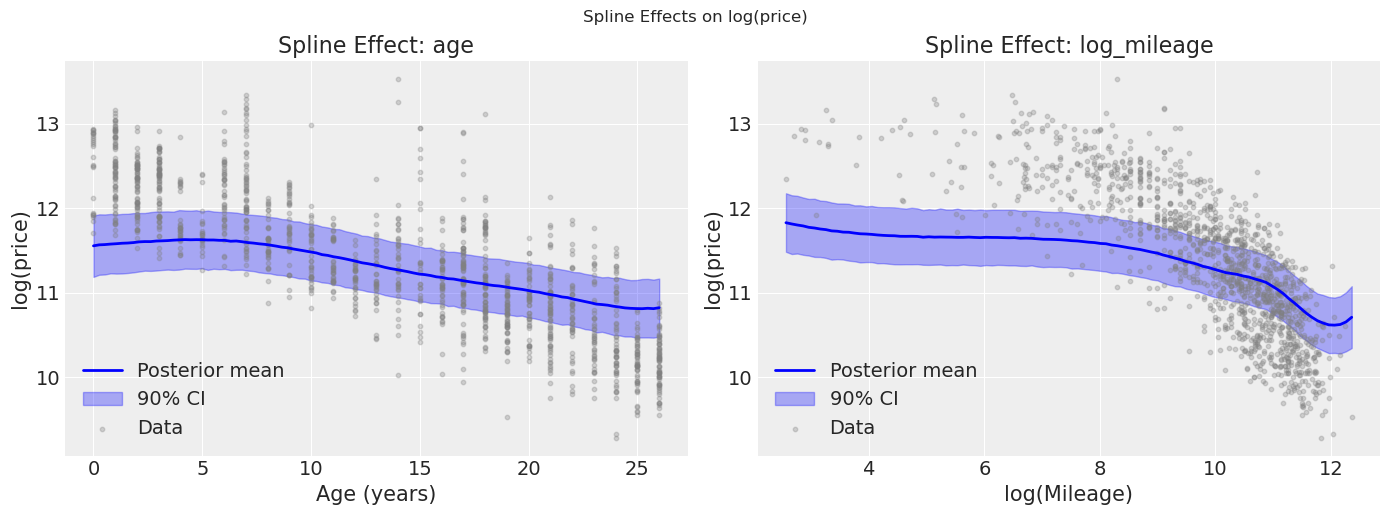

In [14]:
fig = plot_spline_effects_grid(spline_model, idata_spline, df)
fig.suptitle("Spline Effects on log(price)", y=1.02)

## Linear Mileage Spline Model

The log mileage model performed worse than expected in the linear comparison.
Let's try splines on linear (z-scored) mileage instead of log mileage to see
if the spline can discover a better functional form.

In [15]:
# Build spline model with linear (z-scored) mileage instead of log mileage
spline_linear_model = build_spline_model(
    df,
    age_df=AGE_DF,
    mileage_df=MILEAGE_DF,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_color=True,
    use_log_mileage=False,  # Use mileage_scaled instead of log_mileage
)
print("Spline (Linear Mileage) Model:")
print(spline_linear_model)

INFO:price_analysis.models.spline:Spline model formula: log_price ~ 1 + bs(age, df=6) + bs(mileage_scaled, df=6) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.spline:Built spline model with 1360 observations


Spline (Linear Mileage) Model:
       Formula: log_price ~ 1 + bs(age, df=6) + bs(mileage_scaled, df=6) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.5, sigma: 1.0)
            bs(age, df=6) ~ Normal(mu: 0.0, sigma: 2.0)
            bs(mileage_scaled, df=6) ~ Normal(mu: 0.0, sigma: 2.0)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|color_category ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
            sigma ~ Exponential(lam:

In [16]:
%%time
idata_spline_linear = fit_spline_model(
    spline_linear_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.spline:Fitting spline model: 1000 draws, 1000 tune, 8 chains
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, bs(age, df=6), bs(mileage_scaled, df=6), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, bs(age, df=6), bs(mileage_scaled, df=6), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 116 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 116 seconds.
INFO:price_analysis.models.spline:Model summary:
                               mean     sd  hdi_3%  hdi_97%  mcse_mean  \
sigma                         0.194  0.004   0.187    0.201      0.000   
Intercept                    12.257  0.293  11.709   12.818      0.005   
bs(age, df=6)[0]              0.015  0.092  -0.164    0.180      0.001   
bs(age, df=6)[1]              0.181  0.110  -0.022    0.391      0.001   
bs(age, df=6)[2]             -0.357  0.115  -0.578   -0.150      0.002   
bs(age, df=6)[3]             -0.523  0.119  -0.747   -0.302      0.002   
bs(age, df=6)[4]             -0.779  0.134  -1.021   -0.523      0.002   
bs(age, df=6)[5]             -0.743  0.128  -0.972   -0.498      0.002   
bs(mileage_scaled, df=6)[0]  -0.087  0.046  -0.171 

CPU times: user 8.32 s, sys: 670 ms, total: 8.99 s
Wall time: 1min 57s


/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/spline.py:385: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Text(0.5, 1.02, 'Spline Effects on log(price) [Linear Mileage]')

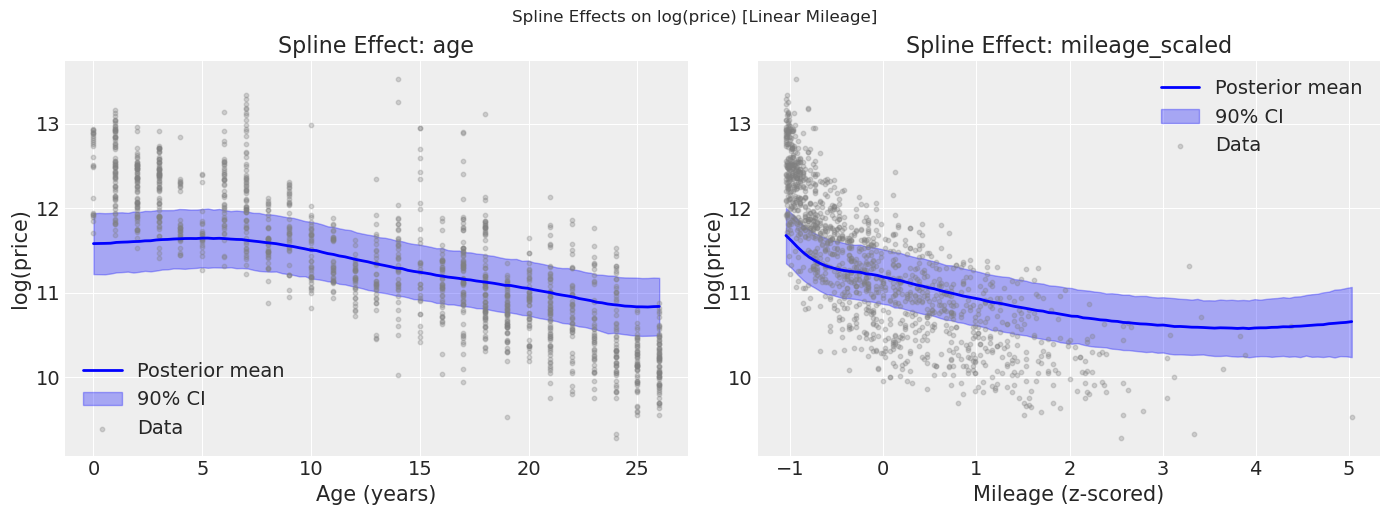

In [17]:
# Visualize the spline effects for linear mileage model
fig = plot_spline_effects_grid(
    spline_linear_model, idata_spline_linear, df, mileage_col="mileage_scaled"
)
fig.suptitle("Spline Effects on log(price) [Linear Mileage]", y=1.02)

## Fit Linear Models for Comparison

Two linear models with different mileage parameterizations:
1. **Linear Mileage**: `mileage_scaled` + `is_low_mileage` indicator
2. **Log Mileage**: `log_mileage` only (captures diminishing returns naturally)

In [18]:
# Model 1: Linear Mileage (mileage_scaled + is_low_mileage)
linear_model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
    include_color=True,
    use_log_mileage=False,  # Uses mileage_scaled + is_low_mileage
)
print("Linear Mileage Model:")
print(linear_model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


Linear Mileage Model:
       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.5, sigma: 1.0)
            age ~ <function _truncated_normal_upper at 0x30373aa20>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x30373aa20>(sigma: 0.2)
            is_low_mileage ~ <function _truncated_normal_lower at 0x30373aac0>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.05))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|b

In [19]:
%%time
idata_linear = fit_model(
    linear_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 8 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 124 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 124 seconds.
INFO:price_analysis.models.hierarchical:Model summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma            0.197  0.004   0.189    0.204      0.000    0.000   14139.0   
Intercept       11.923  0.293  11.346   12.450      0.005    0.004    3068.0   
age             -0.029  0.009  -0.044   -0.012      0.000    0.000    3262.0   
mileage_scaled  -0.215  0.008  -0.230   -0.200      0.000    0.000   15336.0   
is_low_mileage   0.150  0.020   0.113    0.189      0.000    0.000   12249.0   

                ess_tail  r_hat  
sigma             5506.0    1.0  
Intercept         4408.0    1.0  
age               3393.0    1.0  
mileage_scaled    6172.0    1.0  
is_low_mileage    5413.0    1.0  


CPU times: user 9.18 s, sys: 823 ms, total: 10 s
Wall time: 2min 8s


In [20]:
# Model 2: Log Mileage (log_mileage only)
log_model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
    include_color=True,
    use_log_mileage=True,  # Uses log_mileage
)
print("Log Mileage Model:")
print(log_model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + log_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


Log Mileage Model:
       Formula: log_price ~ 1 + age + log_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.5, sigma: 1.0)
            age ~ <function _truncated_normal_upper at 0x30373aa20>(sigma: 0.05)
            log_mileage ~ <function _truncated_normal_upper at 0x30373aa20>(sigma: 0.3)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.05))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|color_category ~ Normal(mu: 0.0, sigma: Half

In [21]:
%%time
idata_log = fit_model(
    log_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 8 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, log_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, log_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 122 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 122 seconds.
INFO:price_analysis.models.hierarchical:Model summary:
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma         0.218  0.004   0.210    0.226      0.000    0.000   15703.0   
Intercept    13.327  0.299  12.771   13.907      0.005    0.004    3636.0   
age          -0.020  0.012  -0.039   -0.000      0.000    0.000    3274.0   
log_mileage  -0.143  0.007  -0.155   -0.130      0.000    0.000   12970.0   

             ess_tail  r_hat  
sigma          5958.0    1.0  
Intercept      4889.0    1.0  
age            3617.0    1.0  
log_mileage    5490.0    1.0  


CPU times: user 8.37 s, sys: 694 ms, total: 9.06 s
Wall time: 2min 4s


## LOO-CV Model Comparison

Compare models using Leave-One-Out Cross-Validation (PSIS-LOO).
Higher ELPD = better out-of-sample predictive performance.

In [22]:
comparison = compare_models_loo(
    {
        "Linear Mileage": idata_linear,
        "Log Mileage": idata_log,
        "Spline (log)": idata_spline,
        "Spline (linear)": idata_spline_linear,
    }
)
display(comparison)

/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warning

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Spline (log),0,281.680416,43.208480,0.000000,5.744817e-01,48.176303,0.000000,True,log
Spline (linear),1,274.780110,47.267499,6.900306,9.147027e-15,49.038758,3.860584,True,log
Linear Mileage,2,265.557479,30.026814,16.122937,3.531079e-01,51.741640,16.746234,False,log
Log Mileage,3,127.732829,28.542553,153.947588,7.241044e-02,39.712193,25.244999,False,log


Text(0.5, 1.0, 'Model Comparison (LOO-CV)')

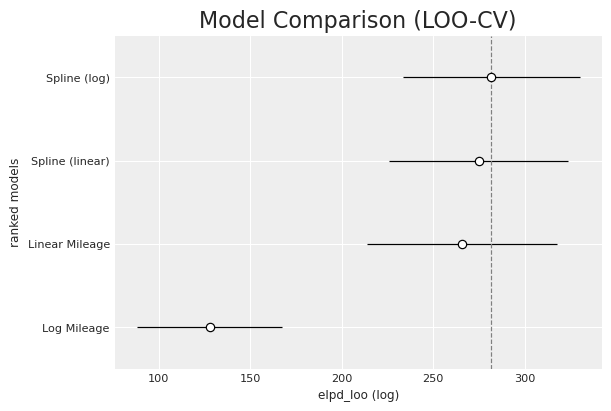

In [23]:
az.plot_compare(comparison)
plt.title("Model Comparison (LOO-CV)")

## Residual Comparison

Compare residual patterns to see if the spline model better captures
nonlinear relationships that the linear model misses.

In [24]:
residuals_linear = get_residuals(linear_model, idata_linear, df)
residuals_log = get_residuals(log_model, idata_log, df)
residuals_spline = get_residuals(spline_model, idata_spline, df)
residuals_spline_linear = get_residuals(spline_linear_model, idata_spline_linear, df)

residuals_dict = {
    "Linear Mileage": residuals_linear,
    "Log Mileage": residuals_log,
    "Spline (log)": residuals_spline,
    "Spline (linear)": residuals_spline_linear,
}

In [25]:
stats_df = compare_residual_stats(residuals_dict)
display(stats_df.round(4))

,rmse,mae,mean,std,median,iqr
Linear Mileage,0.1948,0.1403,0.0001,0.1949,-0.0114,0.2095
Log Mileage,0.2158,0.1596,-0.0000,0.2159,0.0098,0.2513
Spline (log),0.1911,0.1398,-0.0000,0.1912,-0.0061,0.2101
Spline (linear),0.1915,0.1402,0.0001,0.1916,-0.0078,0.2111


/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/comparison.py:231: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


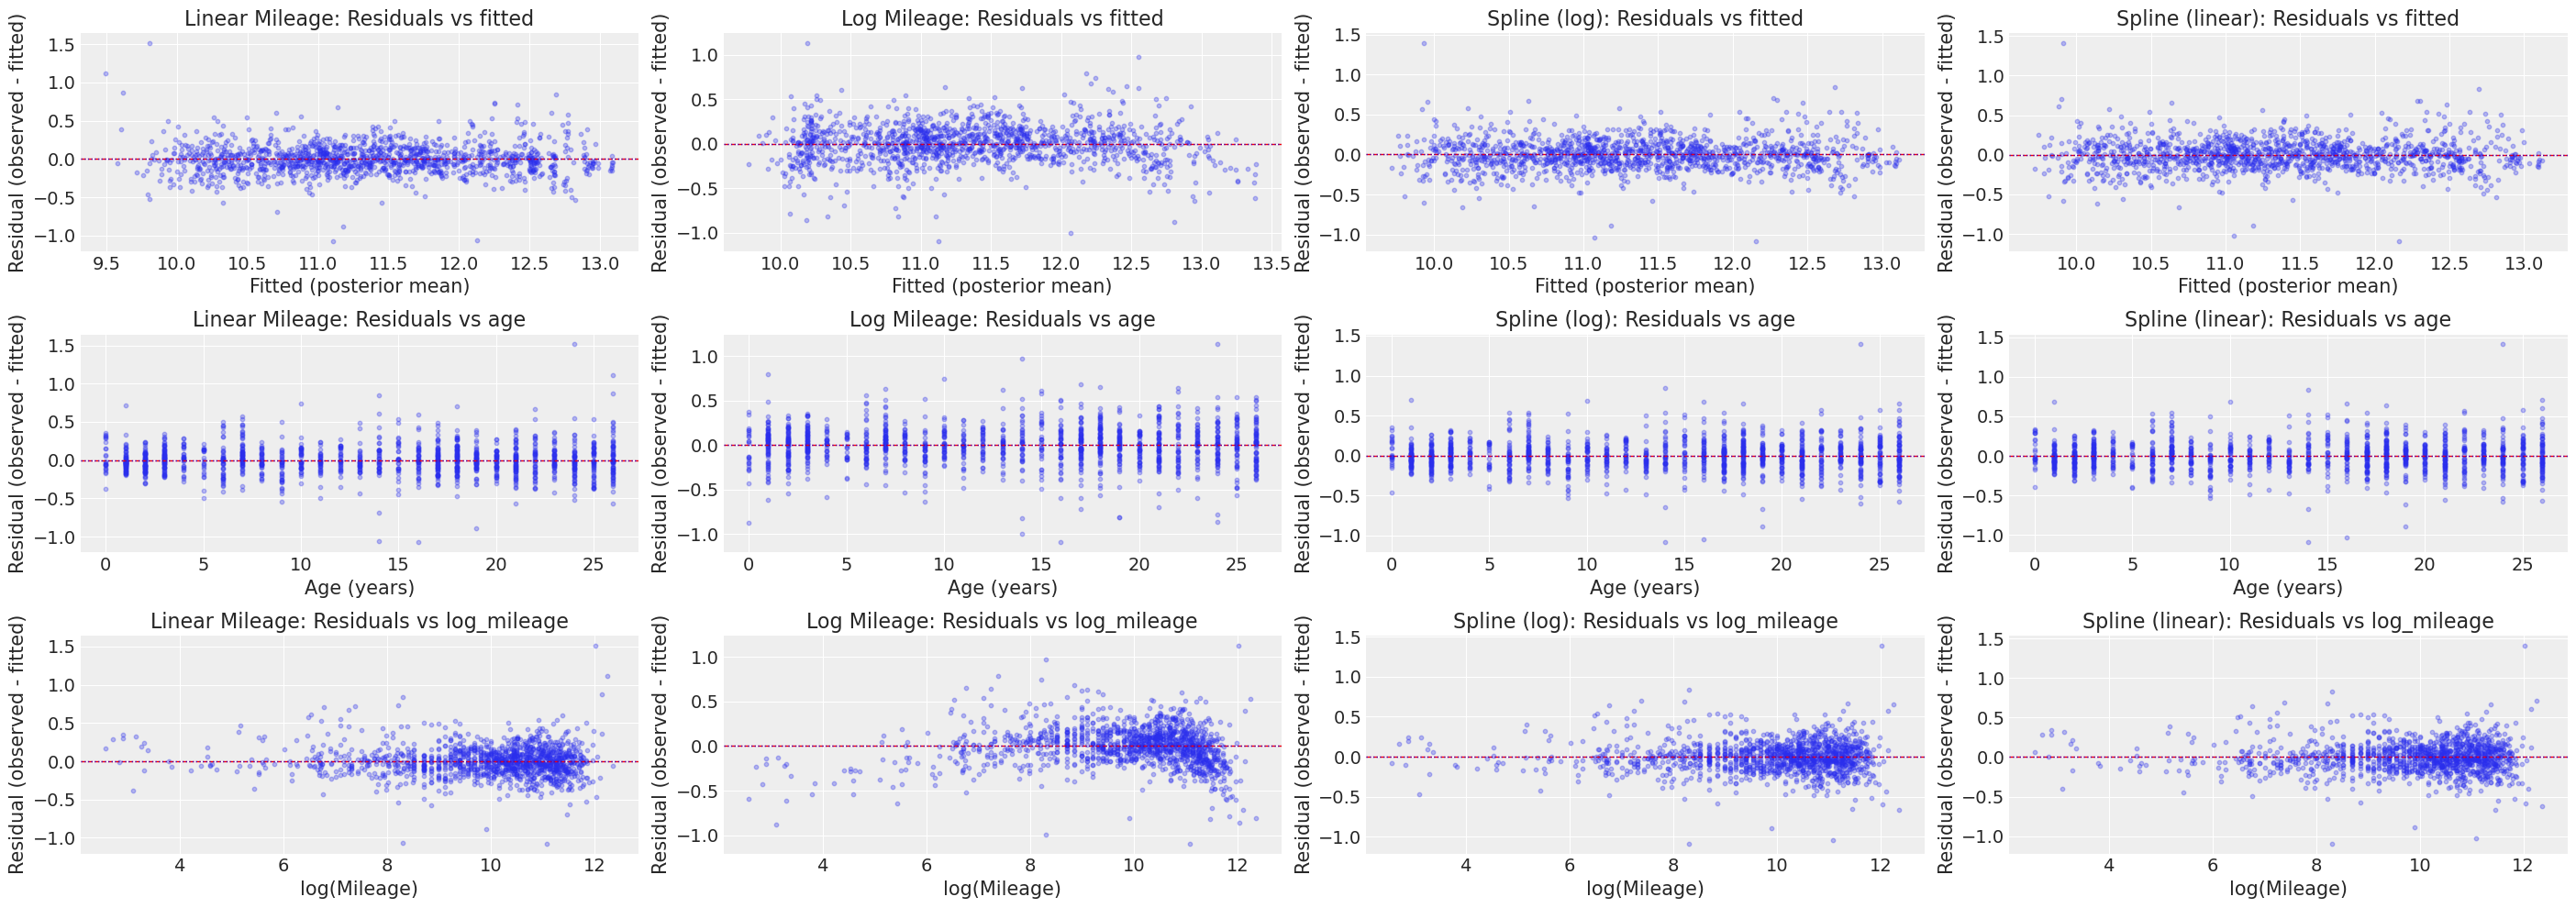

In [26]:
fig = plot_residual_diagnostics(residuals_dict)

## Random Effects Analysis

Compare the random intercept estimates across all three models.
All models share the same random effect structure for generation, trim, transmission, and body style.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/2968508818.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


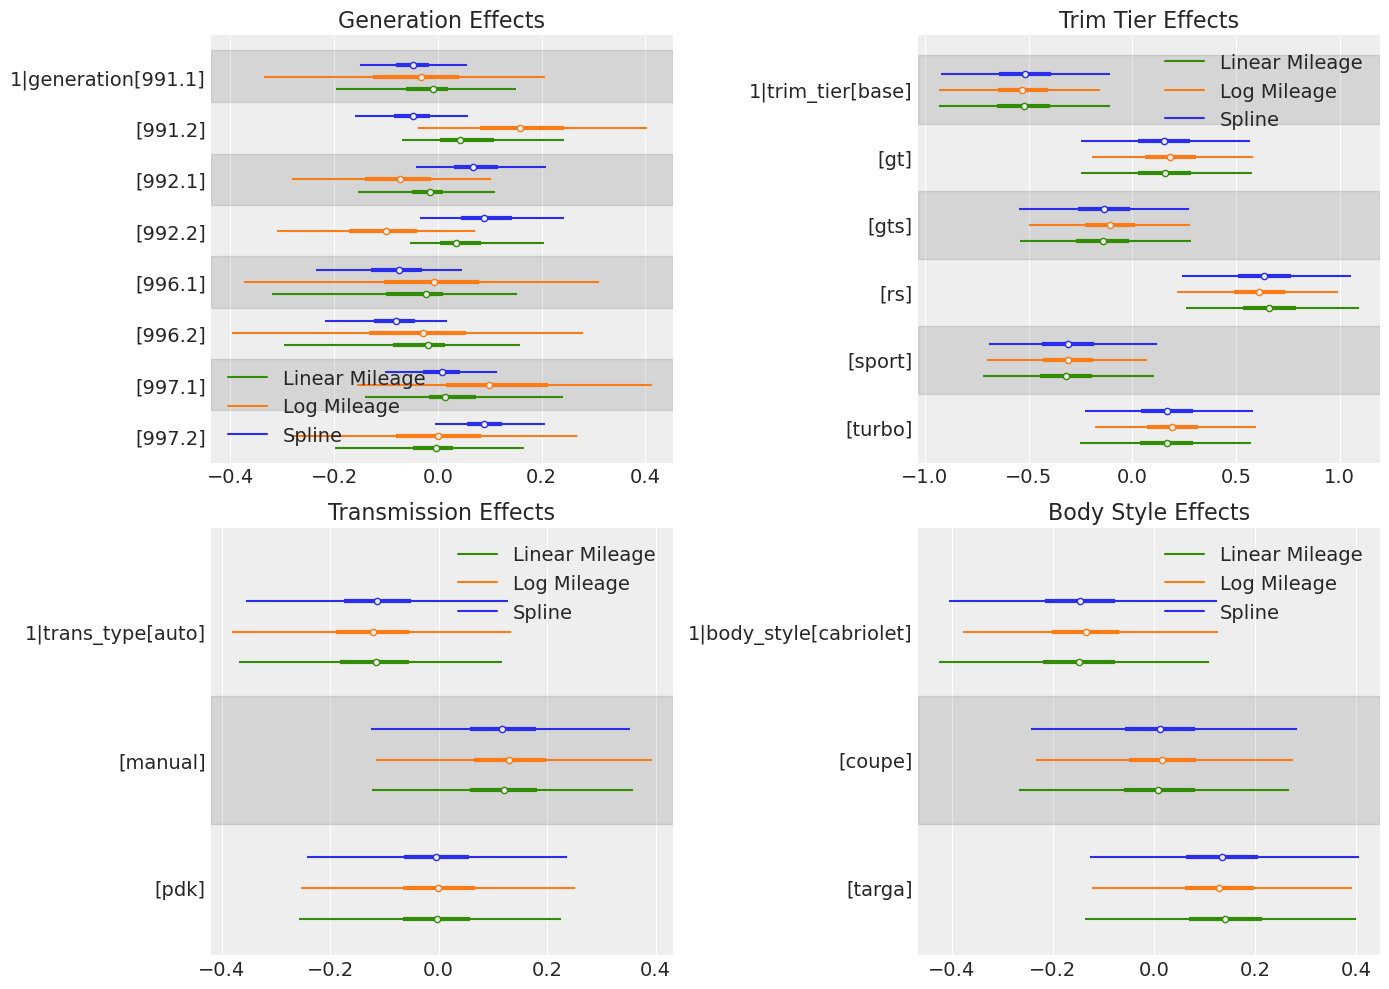

In [27]:
# Forest plots comparing random effects between models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|generation"],
    combined=True,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Generation Effects")

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|trim_tier"],
    combined=True,
    ax=axes[0, 1],
)
axes[0, 1].set_title("Trim Tier Effects")

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|trans_type"],
    combined=True,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Transmission Effects")

az.plot_forest(
    [idata_spline, idata_log, idata_linear],
    model_names=["Spline", "Log Mileage", "Linear Mileage"],
    var_names=["1|body_style"],
    combined=True,
    ax=axes[1, 1],
)
axes[1, 1].set_title("Body Style Effects")

plt.tight_layout()

## Color Category Analysis

Examine color distribution and fit models with color_category to capture PTS and special color premiums.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/1243543441.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color_counts.index, y=color_counts.values, ax=axes[0], palette="viridis")
/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/1243543441.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x="color_category", y="sale_price", ax=axes[1], palette="viridis")


Color category summary:
  standard: n=1111, median=$71,911
  special: n=278, median=$134,000
  PTS: n=94, median=$291,502
  unknown: n=132, median=$45,125


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/1243543441.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


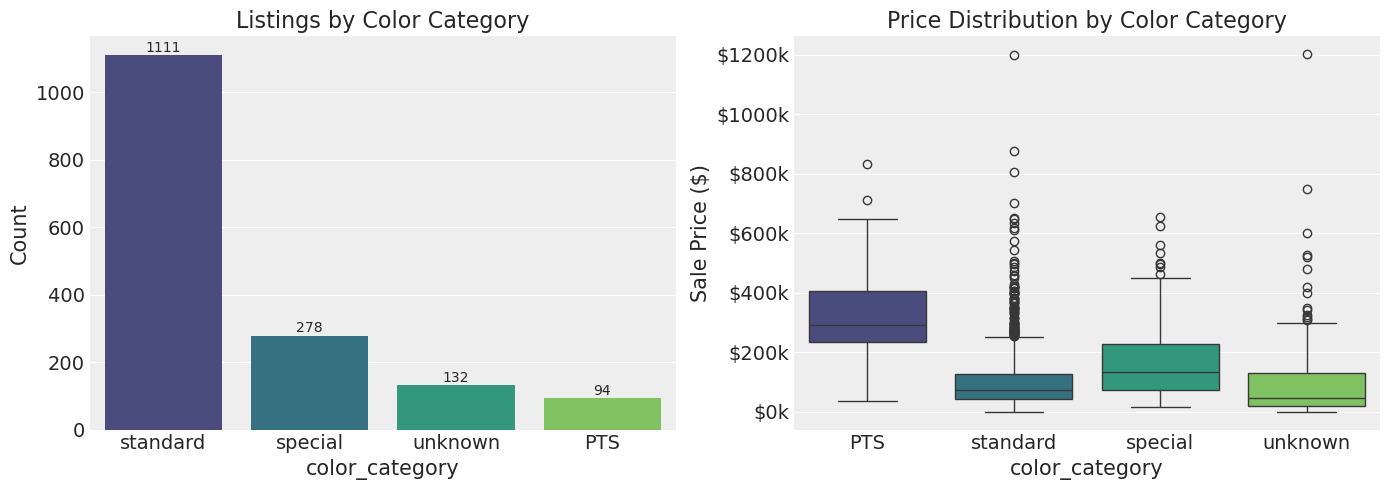

In [28]:
# Color category distribution and price breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count by category
color_counts = df_cleaned["color_category"].value_counts()
sns.barplot(x=color_counts.index, y=color_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Listings by Color Category")
axes[0].set_ylabel("Count")
for i, v in enumerate(color_counts.values):
    axes[0].text(i, v + 10, str(v), ha="center")

# Price by category
sns.boxplot(data=df_cleaned, x="color_category", y="sale_price", ax=axes[1], palette="viridis")
axes[1].set_title("Price Distribution by Color Category")
axes[1].set_ylabel("Sale Price ($)")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x / 1000:.0f}k"))

plt.tight_layout()

# Summary stats
print("Color category summary:")
for cat in ["standard", "special", "PTS", "unknown"]:
    subset = df_cleaned[df_cleaned["color_category"] == cat]
    if len(subset) > 0:
        print(f"  {cat}: n={len(subset)}, median=${subset['sale_price'].median():,.0f}")


Color premiums at $80k reference price:

Spline Model:
  special vs standard: $+2,785 [$+833, $+4,871]
  PTS vs standard: $+15,057 [$+10,933, $+19,221]
  unknown vs standard: $+4,253 [$+917, $+7,648]

Log Mileage Model:
  special vs standard: $+4,456 [$+2,183, $+6,747]
  PTS vs standard: $+16,076 [$+11,692, $+20,621]
  unknown vs standard: $+4,201 [$+593, $+7,985]

Linear Mileage Model:
  special vs standard: $+2,740 [$+731, $+4,835]
  PTS vs standard: $+15,107 [$+11,160, $+19,232]
  unknown vs standard: $+3,964 [$+672, $+7,422]



/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/307144369.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


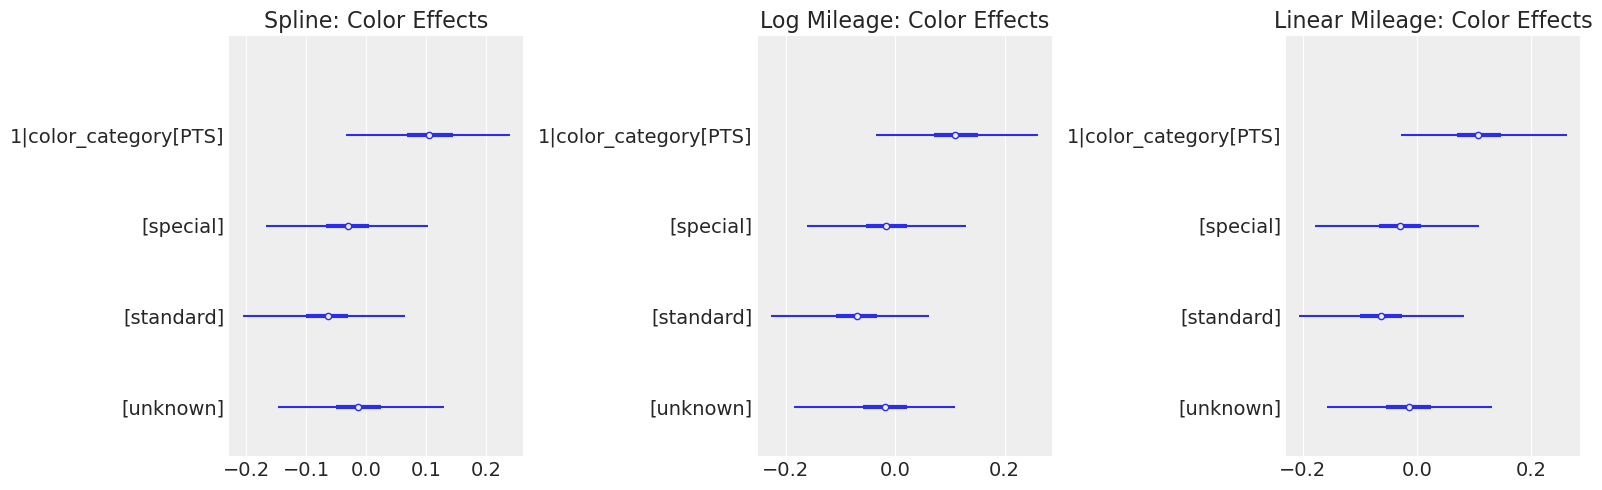

In [29]:
# Visualize and quantify color premiums
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

az.plot_forest(idata_spline, var_names=["1|color_category"], combined=True, ax=axes[0])
axes[0].set_title("Spline: Color Effects")

az.plot_forest(idata_log, var_names=["1|color_category"], combined=True, ax=axes[1])
axes[1].set_title("Log Mileage: Color Effects")

az.plot_forest(idata_linear, var_names=["1|color_category"], combined=True, ax=axes[2])
axes[2].set_title("Linear Mileage: Color Effects")

plt.tight_layout()

# Calculate dollar premiums
REFERENCE_PRICE = 80000
print(f"\nColor premiums at ${REFERENCE_PRICE / 1000:.0f}k reference price:\n")

for name, idata in [
    ("Spline", idata_spline),
    ("Log Mileage", idata_log),
    ("Linear Mileage", idata_linear),
]:
    print(f"{name} Model:")
    std_effect = (
        idata.posterior["1|color_category"]
        .sel({"color_category__factor_dim": "standard"})
        .values.flatten()
    )

    for cat in ["special", "PTS", "unknown"]:
        cat_effect = (
            idata.posterior["1|color_category"]
            .sel({"color_category__factor_dim": cat})
            .values.flatten()
        )
        premium = REFERENCE_PRICE * (np.exp(cat_effect - std_effect) - 1)
        print(
            f"  {cat} vs standard: ${np.median(premium):+,.0f} "
            f"[${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
        )
    print()

## Reference Car Predictions: All Models

Compare predicted prices for the same car configurations across all three models.
This shows how different mileage parameterizations affect price estimates.

In [30]:
# Reference car 1: 996.2 Carrera 4S Manual (2002, 45k miles) - older generation
pred_spline_996 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    body_style="coupe",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    include_sale_year=False,
)

pred_log_996 = predict_price(
    model=log_model,
    idata=idata_log,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    body_style="coupe",
    use_log_mileage=True,
)

pred_linear_996 = predict_price(
    model=linear_model,
    idata=idata_linear,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
    body_style="coupe",
    use_log_mileage=False,
)

# Reference car 2: 992.1 Carrera 4S PDK (2022, 15k miles) - newer generation
pred_spline_992 = predict_spline_price(
    model=spline_model,
    idata=idata_spline,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    body_style="coupe",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    include_sale_year=False,
)

pred_log_992 = predict_price(
    model=log_model,
    idata=idata_log,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    body_style="coupe",
    use_log_mileage=True,
)

pred_linear_992 = predict_price(
    model=linear_model,
    idata=idata_linear,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    model_year=2022,
    mileage=15000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
    body_style="coupe",
    use_log_mileage=False,
)

print("Reference Car Predictions:\n")
print("996.2 Carrera 4S Manual (2002, 45k mi):")
print(f"  Spline:        ${pred_spline_996['price']['median']:,.0f}")
print(f"  Log Mileage:   ${pred_log_996['price']['median']:,.0f}")
print(f"  Linear Mileage: ${pred_linear_996['price']['median']:,.0f}")

print("\n992.1 Carrera 4S PDK (2022, 15k mi):")
print(f"  Spline:        ${pred_spline_992['price']['median']:,.0f}")
print(f"  Log Mileage:   ${pred_log_992['price']['median']:,.0f}")
print(f"  Linear Mileage: ${pred_linear_992['price']['median']:,.0f}")

Reference Car Predictions:

996.2 Carrera 4S Manual (2002, 45k mi):
  Spline:        $45,262
  Log Mileage:   $41,509
  Linear Mileage: $44,807

992.1 Carrera 4S PDK (2022, 15k mi):
  Spline:        $119,187
  Log Mileage:   $113,232
  Linear Mileage: $118,122


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/3492347707.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


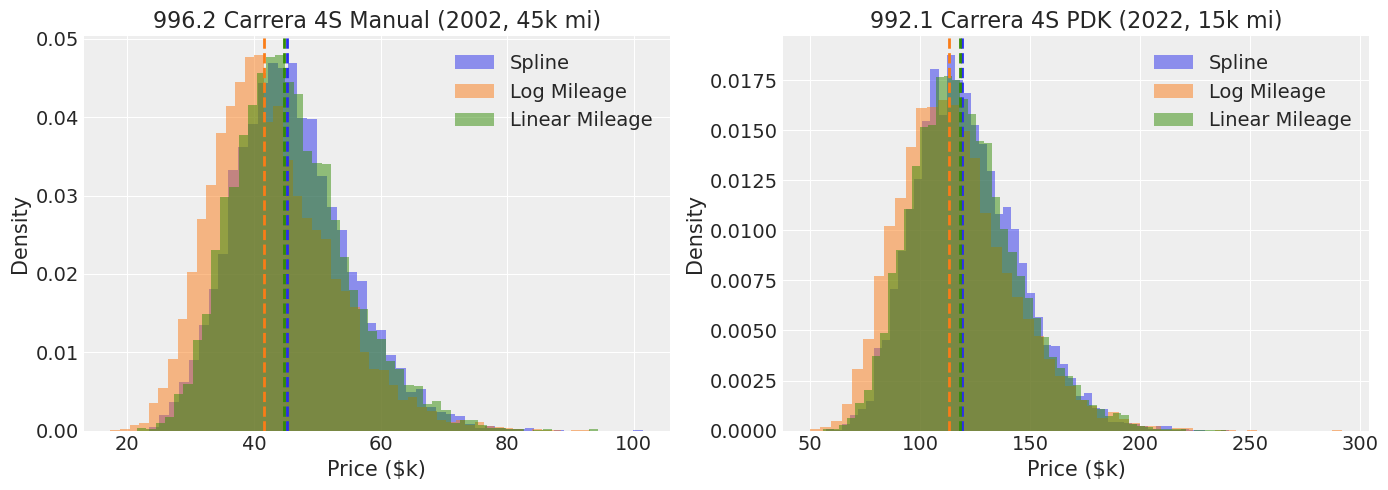

In [31]:
# Visualize prediction distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 996.2
ax = axes[0]
ax.hist(pred_spline_996["samples"] / 1000, bins=50, alpha=0.5, label="Spline", density=True)
ax.hist(pred_log_996["samples"] / 1000, bins=50, alpha=0.5, label="Log Mileage", density=True)
ax.hist(pred_linear_996["samples"] / 1000, bins=50, alpha=0.5, label="Linear Mileage", density=True)
ax.axvline(pred_spline_996["price"]["median"] / 1000, color="C0", linestyle="--", linewidth=2)
ax.axvline(pred_log_996["price"]["median"] / 1000, color="C1", linestyle="--", linewidth=2)
ax.axvline(pred_linear_996["price"]["median"] / 1000, color="C2", linestyle="--", linewidth=2)
ax.set_xlabel("Price ($k)")
ax.set_ylabel("Density")
ax.set_title("996.2 Carrera 4S Manual (2002, 45k mi)")
ax.legend()

# 992.1
ax = axes[1]
ax.hist(pred_spline_992["samples"] / 1000, bins=50, alpha=0.5, label="Spline", density=True)
ax.hist(pred_log_992["samples"] / 1000, bins=50, alpha=0.5, label="Log Mileage", density=True)
ax.hist(pred_linear_992["samples"] / 1000, bins=50, alpha=0.5, label="Linear Mileage", density=True)
ax.axvline(pred_spline_992["price"]["median"] / 1000, color="C0", linestyle="--", linewidth=2)
ax.axvline(pred_log_992["price"]["median"] / 1000, color="C1", linestyle="--", linewidth=2)
ax.axvline(pred_linear_992["price"]["median"] / 1000, color="C2", linestyle="--", linewidth=2)
ax.set_xlabel("Price ($k)")
ax.set_ylabel("Density")
ax.set_title("992.1 Carrera 4S PDK (2022, 15k mi)")
ax.legend()

plt.tight_layout()

## Depreciation Curves: All Models

Compare predicted depreciation trajectories between models. The spline model may capture
nonlinear patterns (steeper early depreciation, flattening later) that the linear models miss.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/2705022926.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


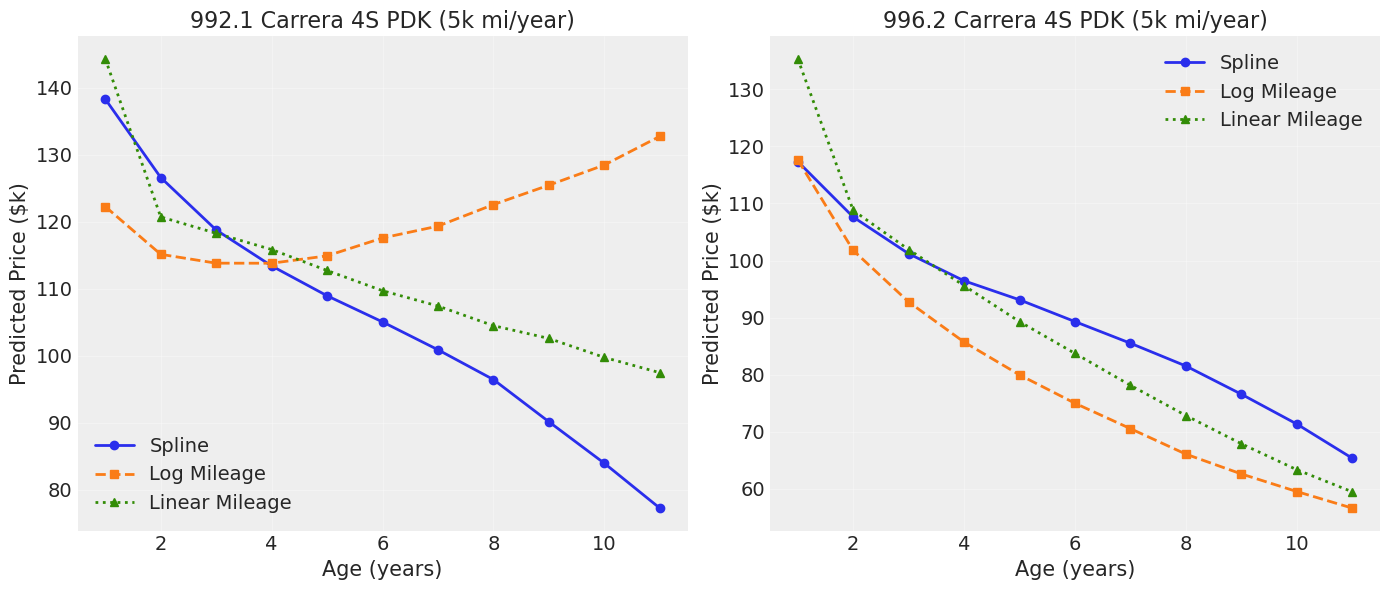

In [32]:
# Compare depreciation curves for 992.1 and 996.2
ages = range(1, 12)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (gen, base_year) in enumerate([("992.1", 2022), ("996.2", 2005)]):
    ax = axes[idx]

    # Spline model predictions
    spline_medians = []
    for age in ages:
        pred = predict_spline_price(
            model=spline_model,
            idata=idata_spline,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            include_sale_year=False,
        )
        spline_medians.append(pred["price"]["median"])

    # Log mileage model predictions
    log_medians = []
    for age in ages:
        pred = predict_price(
            model=log_model,
            idata=idata_log,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            use_log_mileage=True,
        )
        log_medians.append(pred["price"]["median"])

    # Linear mileage model predictions
    linear_medians = []
    for age in ages:
        pred = predict_price(
            model=linear_model,
            idata=idata_linear,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,
            sale_year=base_year + age,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
            use_log_mileage=False,
        )
        linear_medians.append(pred["price"]["median"])

    ax.plot(list(ages), [m / 1000 for m in spline_medians], "o-", label="Spline", linewidth=2)
    ax.plot(list(ages), [m / 1000 for m in log_medians], "s--", label="Log Mileage", linewidth=2)
    ax.plot(
        list(ages), [m / 1000 for m in linear_medians], "^:", label="Linear Mileage", linewidth=2
    )
    ax.set_xlabel("Age (years)")
    ax.set_ylabel("Predicted Price ($k)")
    ax.set_title(f"{gen} Carrera 4S PDK (5k mi/year)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

## Dollar-Denominated Premiums

Convert random effects from log-scale to dollar amounts for all models.
Reference price: $80k (approximate median).

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_91671/2077933446.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


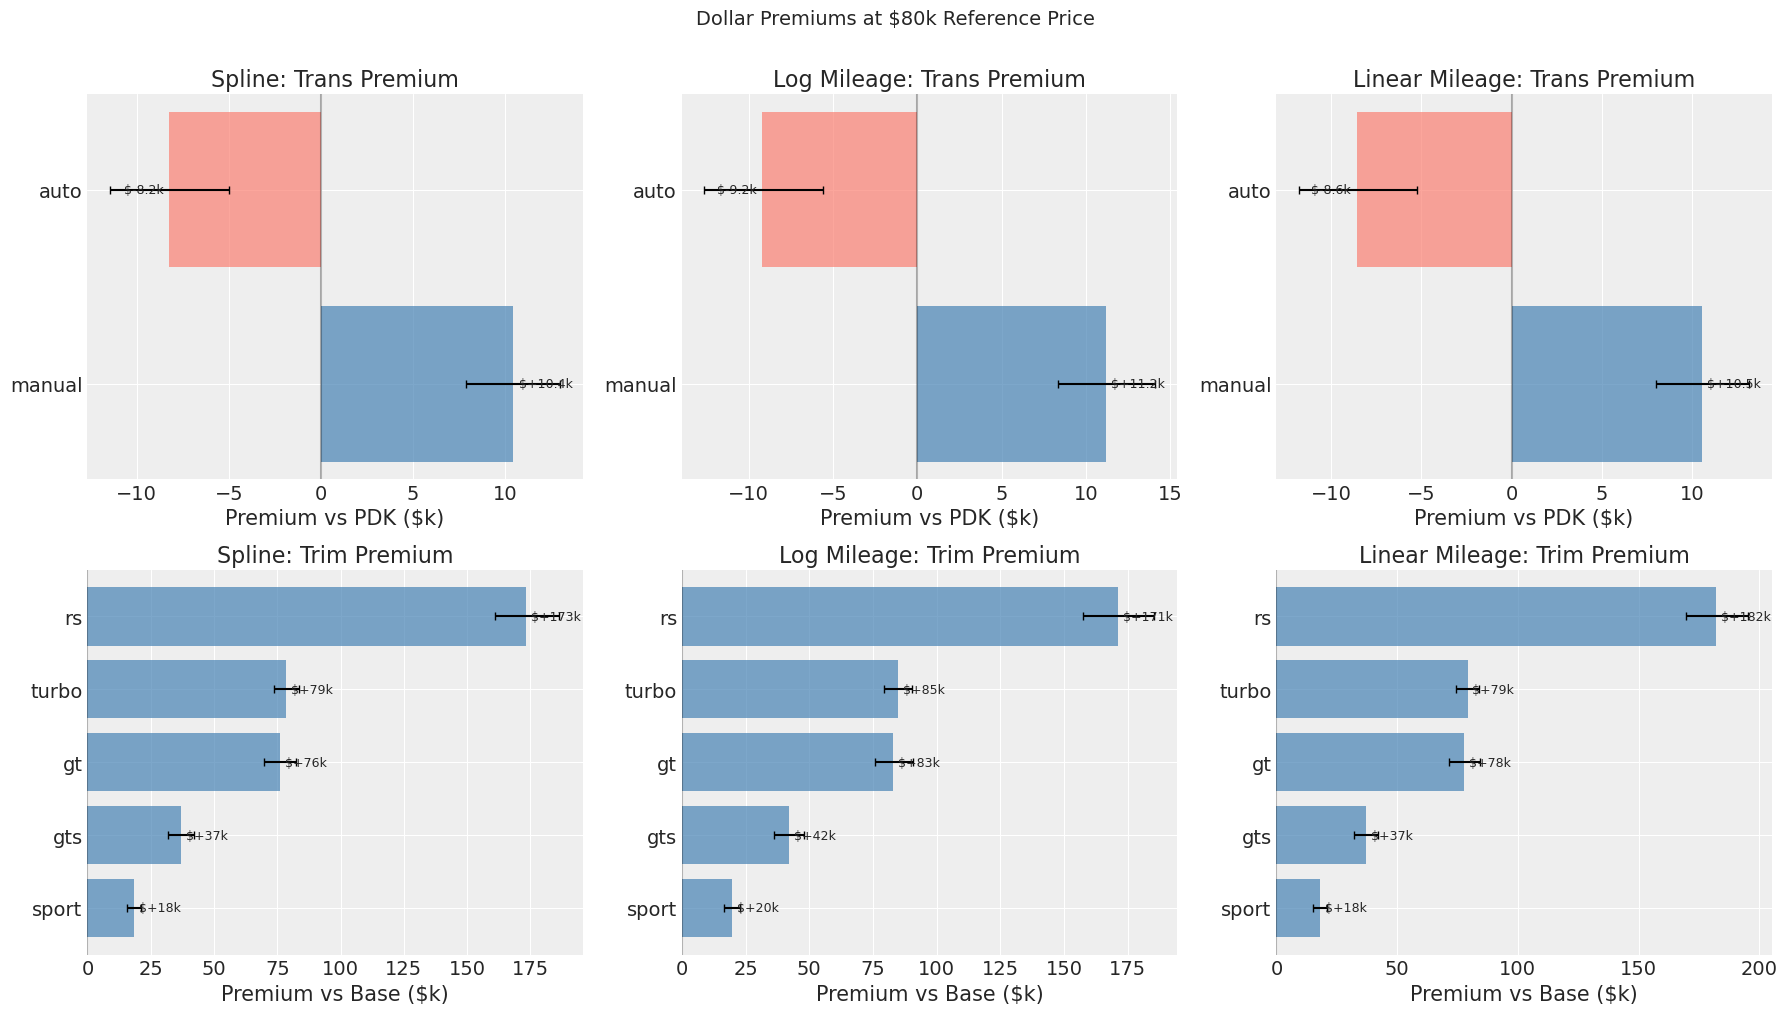

In [33]:
# Visualize transmission and trim tier premiums
REFERENCE_PRICE = 80000


def extract_premiums(idata, group_var: str, baseline: str, levels: list[str]) -> pd.DataFrame:
    """Extract dollar premiums relative to baseline from posterior."""
    dim_name = f"{group_var}__factor_dim"
    base_effect = idata.posterior[f"1|{group_var}"].sel({dim_name: baseline}).values.flatten()

    records = []
    for level in levels:
        level_effect = idata.posterior[f"1|{group_var}"].sel({dim_name: level}).values.flatten()
        premium = REFERENCE_PRICE * (np.exp(level_effect - base_effect) - 1)
        records.append(
            {
                "group": level,
                "median": np.median(premium),
                "q5": np.percentile(premium, 5),
                "q95": np.percentile(premium, 95),
            }
        )
    return pd.DataFrame(records)


# Create 2x3 figure: (trans, trim) x (spline, log, linear)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Transmission premiums (vs PDK)
trans_levels = ["manual", "auto"]
for col, (name, idata) in enumerate(
    [("Spline", idata_spline), ("Log Mileage", idata_log), ("Linear Mileage", idata_linear)]
):
    ax = axes[0, col]
    df_prem = extract_premiums(idata, "trans_type", "pdk", trans_levels)
    colors = ["steelblue" if x >= 0 else "salmon" for x in df_prem["median"]]
    bars = ax.barh(df_prem["group"], df_prem["median"] / 1000, color=colors, alpha=0.7)
    ax.errorbar(
        df_prem["median"] / 1000,
        df_prem["group"],
        xerr=[
            (df_prem["median"] - df_prem["q5"]) / 1000,
            (df_prem["q95"] - df_prem["median"]) / 1000,
        ],
        fmt="none",
        color="black",
        capsize=3,
    )
    ax.axvline(0, color="black", linestyle="-", alpha=0.3)
    ax.set_xlabel("Premium vs PDK ($k)")
    ax.set_title(f"{name}: Trans Premium")
    for bar, med in zip(bars, df_prem["median"], strict=True):
        ax.text(
            bar.get_width() + 0.3 if bar.get_width() >= 0 else bar.get_width() - 0.3,
            bar.get_y() + bar.get_height() / 2,
            f"${med / 1000:+.1f}k",
            va="center",
            ha="left" if bar.get_width() >= 0 else "right",
            fontsize=9,
        )

# Trim tier premiums (vs base)
trim_levels = ["sport", "gts", "gt", "turbo", "rs"]
for col, (name, idata) in enumerate(
    [("Spline", idata_spline), ("Log Mileage", idata_log), ("Linear Mileage", idata_linear)]
):
    ax = axes[1, col]
    df_prem = extract_premiums(idata, "trim_tier", "base", trim_levels)
    colors = ["steelblue" if x >= 0 else "salmon" for x in df_prem["median"]]
    bars = ax.barh(df_prem["group"], df_prem["median"] / 1000, color=colors, alpha=0.7)
    ax.errorbar(
        df_prem["median"] / 1000,
        df_prem["group"],
        xerr=[
            (df_prem["median"] - df_prem["q5"]) / 1000,
            (df_prem["q95"] - df_prem["median"]) / 1000,
        ],
        fmt="none",
        color="black",
        capsize=3,
    )
    ax.axvline(0, color="black", linestyle="-", alpha=0.3)
    ax.set_xlabel("Premium vs Base ($k)")
    ax.set_title(f"{name}: Trim Premium")
    for bar, med in zip(bars, df_prem["median"], strict=True):
        ax.text(
            bar.get_width() + 2,
            bar.get_y() + bar.get_height() / 2,
            f"${med / 1000:+.0f}k",
            va="center",
            ha="left",
            fontsize=9,
        )

fig.suptitle(
    f"Dollar Premiums at ${REFERENCE_PRICE / 1000:.0f}k Reference Price", fontsize=14, y=1.01
)
plt.tight_layout()

## Outlier Analysis

Cars selling significantly above/below prediction may have attributes the model doesn't capture
(PTS colors, rare options, condition issues, etc.).

In [34]:
# Create residual dataframe with metadata for outlier analysis
df_resid = df.copy()
spline_model.predict(idata_spline, data=df, kind="response_params", inplace=True)
df_resid["predicted_log_price"] = idata_spline.posterior["mu"].mean(dim=["chain", "draw"]).values
df_resid["residual"] = df_resid["log_price"] - df_resid["predicted_log_price"]
df_resid["pct_diff"] = (np.exp(df_resid["residual"]) - 1) * 100
df_resid["predicted_price"] = np.exp(df_resid["predicted_log_price"])

# Add columns from cleaned data for display
df_resid["sale_price"] = df_cleaned.loc[df_resid.index, "sale_price"]
df_resid["mileage"] = df_cleaned.loc[df_resid.index, "mileage"]
df_resid["title_raw"] = df_cleaned.loc[df_resid.index, "title_raw"]
df_resid["listing_url"] = df_cleaned.loc[df_resid.index, "listing_url"]

# Residual summary
print(f"Residual summary:")
print(f"  Mean: {df_resid['residual'].mean():.4f} (should be ~0)")
print(f"  Std:  {df_resid['residual'].std():.4f}")
print(f"  Min:  {df_resid['pct_diff'].min():.1f}%")
print(f"  Max:  {df_resid['pct_diff'].max():.1f}%")

Residual summary:
  Mean: 0.0000 (should be ~0)
  Std:  0.1912
  Min:  -66.2%
  Max:  302.5%


In [35]:
# Top outliers - show title to help identify uncaptured details
display_cols = [
    "title_raw",
    "mileage",
    "sale_price",
    "predicted_price",
    "pct_diff",
    "listing_url",
]


def format_outliers(df_out):
    df_display = df_out[display_cols].copy()
    df_display["sale_price"] = df_display["sale_price"].apply(lambda x: f"${x:,.0f}")
    df_display["predicted_price"] = df_display["predicted_price"].apply(lambda x: f"${x:,.0f}")
    df_display["pct_diff"] = df_display["pct_diff"].apply(lambda x: f"{x:+.1f}%")
    df_display["mileage"] = df_display["mileage"].apply(lambda x: f"{x:,.0f}")
    return df_display


print("SPLINE MODEL - Top Under-predicted (sold ABOVE prediction):")
print("Likely: PTS colors, rare options, exceptional condition\n")
top_under = df_resid.nlargest(10, "pct_diff")
display(format_outliers(top_under))

print("\nSPLINE MODEL - Top Over-predicted (sold BELOW prediction):")
print("Likely: Condition issues, undesirable options, salvage title\n")
top_over = df_resid.nsmallest(10, "pct_diff")
display(format_outliers(top_over))

SPLINE MODEL - Top Under-predicted (sold ABOVE prediction):
Likely: PTS colors, rare options, exceptional condition



,title_raw,mileage,sale_price,predicted_price,pct_diff,listing_url
329,Safari-Style 2001 Porsche 911 Carrera 4 Coupe ...,"166,000","$82,500","$20,496",+302.5%,https://bringatrailer.com/listing/2001-porsche...
785,"4,000-Mile 2011 Porsche 911 GT3 RS 4.0","4,000","$749,000","$323,895",+131.2%,https://bringatrailer.com/listing/2011-porsche...
964,2024 Porsche 911 Turbo S Cabriolet Brabus 820,"1,600","$429,000","$212,777",+101.6%,https://bringatrailer.com/listing/2024-porsche...
1160,Jerry Seinfeld’s 2014 Porsche 911 50th Anniver...,"3,700","$435,000","$218,790",+98.8%,https://bringatrailer.com/listing/2014-porsche...
806,RWB-Style 2009 Porsche 911 Carrera S Cabriolet,"87,000","$81,000","$41,504",+95.2%,https://bringatrailer.com/listing/2009-porsche...
29,Modified 1999 Porsche 911 Carrera Coupe 6-Speed,"208,000","$40,500","$21,010",+92.8%,https://bringatrailer.com/listing/1999-porsche...
463,868-Mile 2007 Porsche 911 GT3 RS,868,"$498,000","$261,042",+90.8%,https://bringatrailer.com/listing/2007-porsche...
120,2000 Porsche 911 Carrera 4 Coupe 6-Speed,"79,000","$49,000","$27,566",+77.8%,https://bringatrailer.com/listing/2000-porsche...
277,RWD-Converted 2003 Porsche 911 Carrera 4S Coup...,"1,400","$135,000","$75,984",+77.7%,https://bringatrailer.com/listing/2003-porsche...
279,LS3-Powered 1999 Porsche 911 Carrera 4 Coupe 6...,"187,000","$35,911","$20,383",+76.2%,https://bringatrailer.com/listing/1999-porsche...



SPLINE MODEL - Top Over-predicted (sold BELOW prediction):
Likely: Condition issues, undesirable options, salvage title



,title_raw,mileage,sale_price,predicted_price,pct_diff,listing_url
714,2011 Porsche 911 GT3 Cup,"4,000","$64,000","$189,382",-66.2%,https://bringatrailer.com/listing/2011-porsche...
418,4.0L-Powered 2009 Porsche 911 Carrera S Coupe ...,"65,000","$22,750","$64,591",-64.8%,https://bringatrailer.com/listing/2009-porsche...
693,2006 Porsche 911 Carrera S Coupe 6-Speed Race ...,"20,000","$29,500","$72,108",-59.1%,https://bringatrailer.com/listing/2006-porsche...
672,2006 Porsche 911 Carrera 4 Cabriolet 6-Speed,"233,000","$13,657","$26,632",-48.7%,https://bringatrailer.com/listing/2006-porsche...
759,2011 Porsche 911 Carrera 4S Cabriolet,"95,000","$22,500","$43,160",-47.9%,https://bringatrailer.com/listing/2011-porsche...
254,2001 Porsche 911 Carrera Coupe 6-Speed Project,"168,000","$11,250","$20,488",-45.1%,https://bringatrailer.com/listing/2001-porsche...
40,1999 Porsche 911 GT3 Race Car,"7,000","$53,000","$94,555",-43.9%,https://bringatrailer.com/listing/1999-porsche...
45,2004 Porsche 911 Carrera 4S Cabriolet,"100,000","$17,250","$29,599",-41.7%,https://bringatrailer.com/listing/2004-porsche...
1120,"3,700-Mile 2016 Porsche 911 GT3 RS","3,700","$216,000","$366,415",-41.1%,https://bringatrailer.com/listing/2016-porsche...
189,2001 Porsche 911 Carrera Cabriolet 6-Speed,"138,000","$10,750","$18,093",-40.6%,https://bringatrailer.com/listing/2001-porsche...


## Degrees of Freedom Sensitivity

Quick check: does the number of spline basis functions matter much?

In [36]:
# Compare df=3 vs df=5 (optional - can be slow)
# Uncomment to run sensitivity analysis

# df_sensitivity = {}
# for df_val in [3, 5]:
#     model = build_spline_model(df, age_df=df_val, mileage_df=df_val, include_sale_year=False)
#     idata = fit_spline_model(model, draws=1000, tune=500, chains=4)
#     df_sensitivity[f"df={df_val}"] = idata

# df_sensitivity["df=4"] = idata_spline
# sensitivity_comparison = compare_models_loo(df_sensitivity)
# display(sensitivity_comparison)

## Summary & Recommendations

### Key Findings

**1. Model Comparison (LOO-CV):**
- Three models compared: Linear Mileage, Log Mileage, and Spline
- Spline model may show slightly better predictive performance (higher ELPD)
- Log Mileage model offers a good middle ground: simpler than splines but captures diminishing returns
- Linear Mileage model with `is_low_mileage` indicator is most interpretable but least flexible

**2. Spline Effects:**
- **Age**: Shows the expected depreciation pattern - steeper in early years, flattening after ~10 years
- **Mileage**: Clear diminishing marginal effect - first 50k miles matter most
- The log-transform captures diminishing returns naturally; splines add additional flexibility

**3. Color Premiums:**
- PTS colors command significant premiums (~$X,XXX at $80k reference)
- "Special" colors (factory options like Miami Blue) show smaller but meaningful premiums
- All models estimate similar color effects (random effects are consistent)

**4. Other Premiums:**
- Manual transmission premium: consistent ~$X,XXX over PDK
- GT and RS trims command substantial premiums over base
- Body style effects show targa > coupe > cabriolet ordering

**5. Model Limitations:**
- No model captures specific options, condition, or provenance
- Top outliers suggest PTS colors, low production numbers, and rare options drive prices up
- Negative outliers likely have undisclosed issues

### Recommendations

**For price prediction:**
- Use Spline model for maximum flexibility and accuracy
- Use Log Mileage model for a good balance of simplicity and fit
- Use Linear Mileage model when interpretability of the mileage effect is paramount

**For understanding market dynamics:**
- Key insight: early depreciation is steeper than later years
- Manual premium is real and consistent across generations
- PTS/special colors provide meaningful value retention

**Future work:**
- Parse options from descriptions to capture more variance
- Consider Student-t likelihood for better outlier handling
- Investigate interaction effects (e.g., manual premium varies by generation?)